
CLUSTER ANALYSIS

1. Cluster Distribution:
cluster_name
Stable Majority     1791
Volatile Critics     301
Flip-Floppers        233
Improvers             39
Name: count, dtype: int64

Total users: 2364

2. Detailed Cluster Statistics:
                 drift_slope                         drift_delta          \
                        mean     std     min     max        mean     std   
cluster_name                                                               
Flip-Floppers        -0.0191  0.0993 -0.9180  0.1746     -0.0982  0.7559   
Improvers             0.2846  0.1943  0.1466  1.2750      0.6796  0.4171   
Stable Majority      -0.0031  0.0414 -0.8279  0.1434     -0.0204  0.3793   
Volatile Critics     -0.0007  0.0203 -0.1166  0.1355     -0.0411  0.8102   

                      tv         flip_rate          
                    mean     std      mean     std  
cluster_name                                        
Flip-Floppers     1.7515  0.7944    0.7067  0.2179  
Improvers         0.

C:\Users\shubh\AppData\Local\Temp\ipykernel_10848\3308438296.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=traj_valid, x="cluster_name", y=col, ax=ax, palette="Set2")
C:\Users\shubh\AppData\Local\Temp\ipykernel_10848\3308438296.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=traj_valid, x="cluster_name", y=col, ax=ax, palette="Set2")
C:\Users\shubh\AppData\Local\Temp\ipykernel_10848\3308438296.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=traj_valid, x="cluster_name", y=col, ax=ax, palette="Set2")
C:\Users\s

  → Saved: cluster_boxplots.png
  → Saved: cluster_radar.png

6. Plotting sample trajectories from each cluster...
  → Saved: cluster_trajectories.png

ANALYSIS COMPLETE


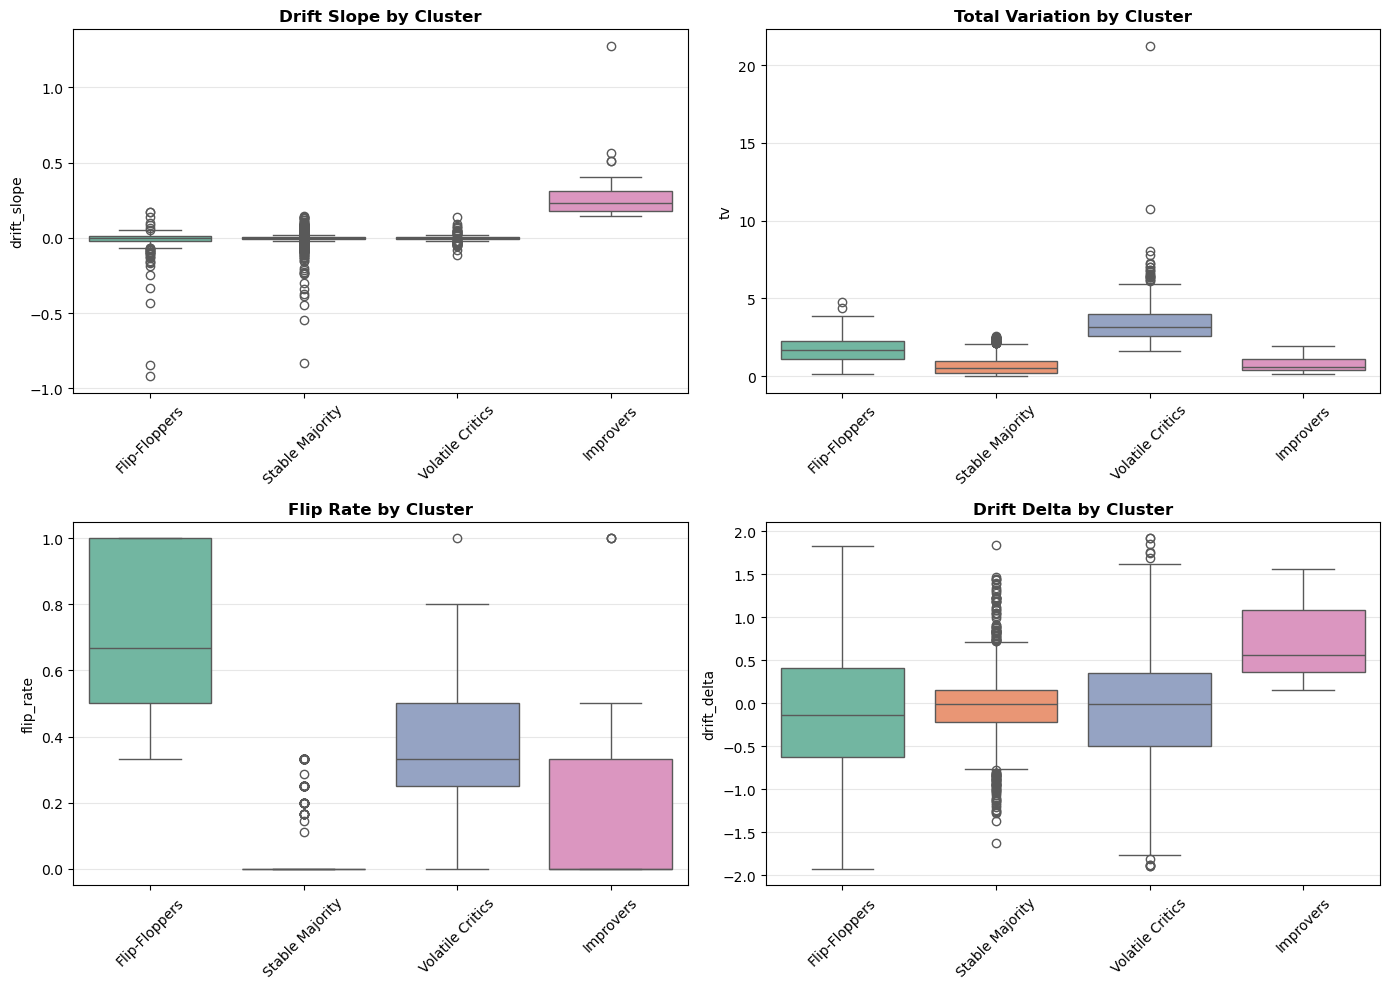

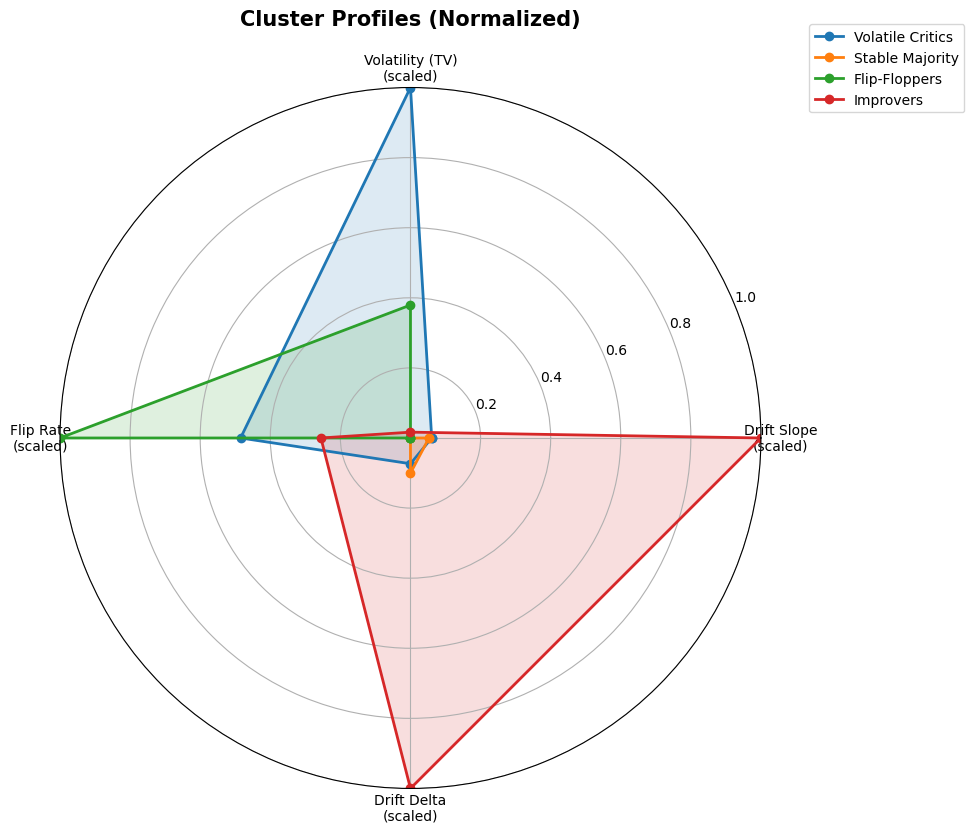

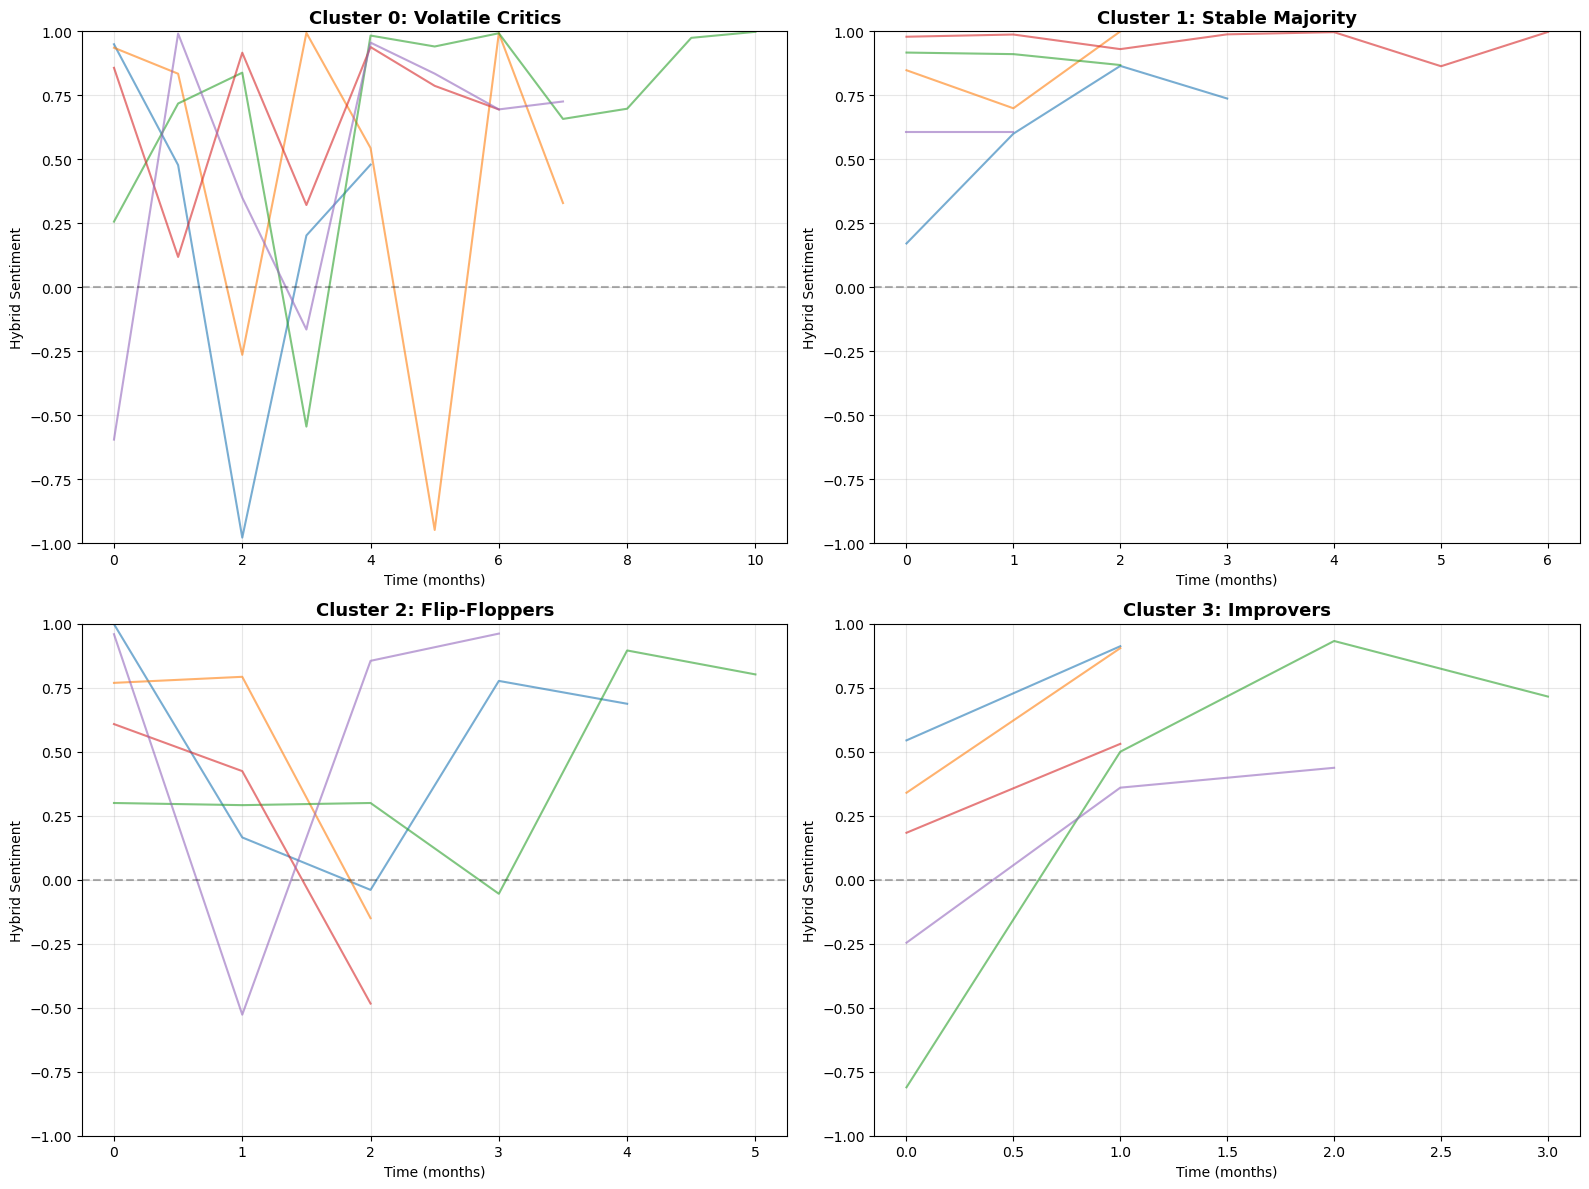

In [1]:
"""
analyze_clusters.py
Deep analysis of discovered user clusters
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data
TRAJ_PATH = "runs/enhanced_v1_20251119_000135/data/user_trajectories.parquet"
MONTHLY_PATH = "runs/enhanced_v1_20251119_000135/data/reviews_monthly.parquet"

traj = pd.read_parquet(TRAJ_PATH)
monthly = pd.read_parquet(MONTHLY_PATH)

# Filter out invalid cluster (-1)
traj_valid = traj[traj["cluster"] >= 0].copy()

# Define cluster names
cluster_names = {
    0: "Volatile Critics",
    1: "Stable Majority", 
    2: "Flip-Floppers",
    3: "Improvers"
}

traj_valid["cluster_name"] = traj_valid["cluster"].map(cluster_names)

print("\n" + "="*70)
print("CLUSTER ANALYSIS")
print("="*70)

# 1. Cluster sizes
print("\n1. Cluster Distribution:")
cluster_dist = traj_valid["cluster_name"].value_counts()
print(cluster_dist)
print(f"\nTotal users: {len(traj_valid)}")

# 2. Detailed statistics per cluster
print("\n2. Detailed Cluster Statistics:")
stats = traj_valid.groupby("cluster_name").agg({
    "drift_slope": ["mean", "std", "min", "max"],
    "drift_delta": ["mean", "std"],
    "tv": ["mean", "std"],
    "flip_rate": ["mean", "std"]
}).round(4)
print(stats)

# 3. Statistical significance test: Are clusters really different?
from scipy import stats as sp_stats

print("\n3. Statistical Tests (ANOVA):")
clusters_list = [traj_valid[traj_valid["cluster"] == i]["drift_slope"].dropna() 
                 for i in range(4)]
f_stat, p_val = sp_stats.f_oneway(*clusters_list)
print(f"Drift Slope across clusters: F={f_stat:.2f}, p={p_val:.4e}")
print(f"  → Clusters are {'SIGNIFICANTLY' if p_val < 0.001 else 'NOT significantly'} different")

# 4. Find most extreme users in each cluster
print("\n4. Most Extreme Users per Cluster:")
for cid in range(4):
    cluster_data = traj_valid[traj_valid["cluster"] == cid]
    
    # Most extreme positive drift
    max_user = cluster_data.loc[cluster_data["drift_slope"].idxmax()]
    print(f"\nCluster {cid} ({cluster_names[cid]}):")
    print(f"  Most positive drift: User {max_user['user_id']}, slope={max_user['drift_slope']:.4f}")
    
    # Most volatile
    max_tv_user = cluster_data.loc[cluster_data["tv"].idxmax()]
    print(f"  Most volatile: User {max_tv_user['user_id']}, TV={max_tv_user['tv']:.2f}")

# 5. Visualizations
print("\n5. Generating cluster comparison plots...")

# Plot 1: Box plots for each metric
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = [
    ("drift_slope", "Drift Slope"),
    ("tv", "Total Variation"),
    ("flip_rate", "Flip Rate"),
    ("drift_delta", "Drift Delta")
]

for ax, (col, title) in zip(axes.flat, metrics):
    sns.boxplot(data=traj_valid, x="cluster_name", y=col, ax=ax, palette="Set2")
    ax.set_title(f"{title} by Cluster", fontsize=12, fontweight="bold")
    ax.set_xlabel("")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig("cluster_boxplots.png", dpi=220, bbox_inches="tight")
print("  → Saved: cluster_boxplots.png")

# Plot 2: Cluster characteristics radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

categories = ['Drift Slope\n(scaled)', 'Volatility (TV)\n(scaled)', 
              'Flip Rate\n(scaled)', 'Drift Delta\n(scaled)']
N = len(categories)

angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

# Normalize metrics to 0-1 scale for radar chart
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

cluster_profiles = []
for cid in range(4):
    cluster_data = traj_valid[traj_valid["cluster"] == cid]
    profile = [
        cluster_data["drift_slope"].mean(),
        cluster_data["tv"].mean(),
        cluster_data["flip_rate"].mean(),
        cluster_data["drift_delta"].mean()
    ]
    cluster_profiles.append(profile)

# Scale all together
profiles_scaled = scaler.fit_transform(cluster_profiles)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for i, (profile, color, name) in enumerate(zip(profiles_scaled, colors, 
                                                [cluster_names[i] for i in range(4)])):
    values = profile.tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=name, color=color)
    ax.fill(angles, values, alpha=0.15, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=10)
ax.set_ylim(0, 1)
ax.set_title("Cluster Profiles (Normalized)", size=15, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.savefig("cluster_radar.png", dpi=220, bbox_inches="tight")
print("  → Saved: cluster_radar.png")

# Plot 3: Sample trajectories from each cluster
print("\n6. Plotting sample trajectories from each cluster...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for cid, ax in enumerate(axes.flat):
    cluster_users = traj_valid[traj_valid["cluster"] == cid].sample(
        min(5, len(traj_valid[traj_valid["cluster"] == cid])), random_state=42
    )["user_id"].tolist()
    
    for uid in cluster_users:
        user_monthly = monthly[monthly["user_id"] == uid].sort_values("month")
        ax.plot(range(len(user_monthly)), user_monthly["sent_hybrid_mean"], 
               alpha=0.6, linewidth=1.5)
    
    ax.axhline(0, color='black', linestyle='--', alpha=0.3)
    ax.set_title(f"Cluster {cid}: {cluster_names[cid]}", fontsize=13, fontweight="bold")
    ax.set_xlabel("Time (months)")
    ax.set_ylabel("Hybrid Sentiment")
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-1, 1)

plt.tight_layout()
plt.savefig("cluster_trajectories.png", dpi=220, bbox_inches="tight")
print("  → Saved: cluster_trajectories.png")

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)
